# Ergebnisse der Zwei-Stufen-XGBoost-Experimente

In diesem Notebook werte ich die gespeicherten Ergebnis-Dateien aus:

- `notebooks/results/two_stage__<EXP_ID>.json`

Jedes JSON gehört zu einem bestimmten Experiment (`EXP_ID`) und enthält:

- Metriken für das Signal-Modell (Train/Val/Test),
- Metriken für das Richtungs-Modell (Train/Val/Test),
- kombinierte 3-Klassen-Auswertung (neutral / up / down) auf dem Test-Split.

Ziel ist es, verschiedene Experimente (z.B. unterschiedliche Label-Parameter
oder Oversampling-Faktoren) **nebeneinander vergleichen** zu können.


In [10]:
import sys
from pathlib import Path
import json

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

# Projektwurzel finden, indem wir nach oben laufen, bis ein Ordner `src` existiert.
cwd = Path.cwd()
project_root = cwd
while not (project_root / "src").is_dir():
    project_root = project_root.parent

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

results_dir = project_root / "notebooks" / "results"
print("Results-Ordner:", results_dir)

# Alle Ergebnisdateien einlesen, die dem Schema two_stage__*.json entsprechen.
json_paths = sorted(results_dir.glob("two_stage__*.json"))
print("Gefundene Experimente:")
for p in json_paths:
    print(" -", p.name)


Results-Ordner: /Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/notebooks/results
Gefundene Experimente:
 - two_stage__v1_h4_thr0p5pct_strict.json
 - two_stage__v2_h4_thr0p5pct_strict_newfeat.json
 - two_stage__v3_h4_thr0p3pct_relaxed.json
 - two_stage__v4_h4_thr0p5pct_tolerant0p3pct.json
 - two_stage__v5_h4_thr0p5pct_tolerant0p3pct_spw1p0.json
 - two_stage__v6_h4_thr0p5pct_tolerant0p3pct_sigdepth2.json
 - two_stage__v7_h4_thr0p5pct_tolerant0p3pct_sigdepth4_n600.json
 - two_stage__v8_h4_thr0p5pct_tolerant0p3pct_sig_easytrain.json


## 1. Übersichtstabelle für Signal- und Richtungs-Modell (Test)

In dieser Zelle sammle ich aus jeder JSON-Datei die wichtigsten Kennzahlen
für den **Test-Split**:

- Signal-Modell (`signal`): Accuracy, Precision, Recall, F1 der Klasse `move`.
- Richtungs-Modell (`direction`): Accuracy, Precision, Recall, F1 der Klasse `up`.

Das Ergebnis ist eine Tabelle, in der jede Zeile ein Experiment (`exp_id`) beschreibt.


In [11]:
rows = []

for path in json_paths:
    with open(path, "r") as f:
        data = json.load(f)

    exp_id = path.stem.replace("two_stage__", "")

    # Signal-Modell (Test)
    sig_test = data["signal"]["test"]
    sig_report = sig_test["report"]
    sig_move = sig_report.get("move", {})  # Klasse 'move'

    # Richtungs-Modell (Test)
    dir_test = data["direction"]["test"]
    dir_report = dir_test["report"]
    dir_up = dir_report.get("up", {})  # Klasse 'up'

    rows.append(
        {
            "exp_id": exp_id,
            # Signal (move)
            "signal_acc": sig_report.get("accuracy", float("nan")),
            "signal_precision_move": sig_move.get("precision", float("nan")),
            "signal_recall_move": sig_move.get("recall", float("nan")),
            "signal_f1_move": sig_move.get("f1-score", float("nan")),
            # Direction (up)
            "direction_acc": dir_report.get("accuracy", float("nan")),
            "direction_precision_up": dir_up.get("precision", float("nan")),
            "direction_recall_up": dir_up.get("recall", float("nan")),
            "direction_f1_up": dir_up.get("f1-score", float("nan")),
        }
    )

summary_df = pd.DataFrame(rows)
summary_df


,exp_id,signal_acc,signal_precision_move,signal_recall_move,signal_f1_move,direction_acc,direction_precision_up,direction_recall_up,direction_f1_up
0,v1_h4_thr0p5pct_strict,0.802752,0.172414,0.208333,0.188679,0.750000,0.700000,0.700000,0.700000
1,v2_h4_thr0p5pct_strict_newfeat,0.834862,0.227273,0.208333,0.217391,0.708333,0.636364,0.700000,0.666667
2,v3_h4_thr0p3pct_relaxed,0.582569,0.772059,0.636364,0.697674,0.690909,0.768293,0.663158,0.711864
3,v4_h4_thr0p5pct_tolerant0p3pct,0.513761,0.544643,0.525862,0.535088,0.741379,0.822581,0.728571,0.772727
4,v5_h4_thr0p5pct_tolerant0p3pct_spw1p0,0.513761,0.544643,0.525862,0.535088,0.741379,0.822581,0.728571,0.772727
5,v6_h4_thr0p5pct_tolerant0p3pct_sigdepth2,0.477064,0.517857,0.250000,0.337209,0.741379,0.822581,0.728571,0.772727
6,v7_h4_thr0p5pct_tolerant0p3pct_sigdepth4_n600,0.518349,0.549550,0.525862,0.537445,0.741379,0.822581,0.728571,0.772727
7,v8_h4_thr0p5pct_tolerant0p3pct_sig_easytrain,0.532110,0.552239,0.637931,0.592000,0.741379,0.822581,0.728571,0.772727


## 2. Experimente visuell vergleichen

Als nächstes stelle ich Precision und Recall der Klasse `move` (Signal-Modell)
und der Klasse `up` (Richtungs-Modell) für alle Experimente als Balkendiagramme dar.


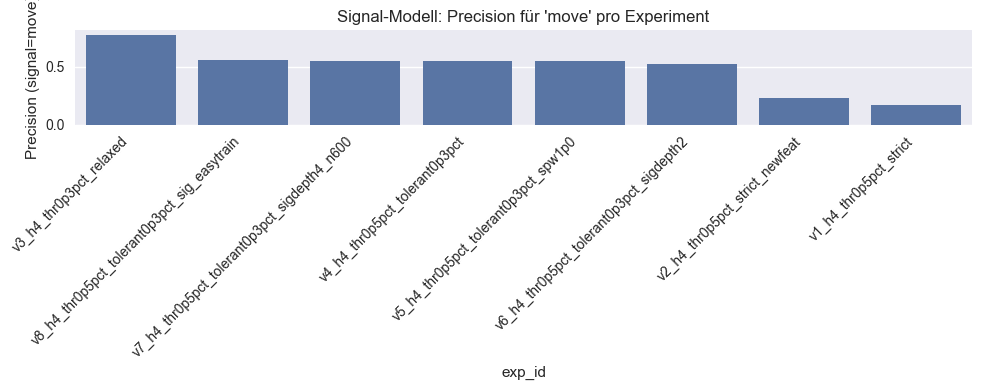

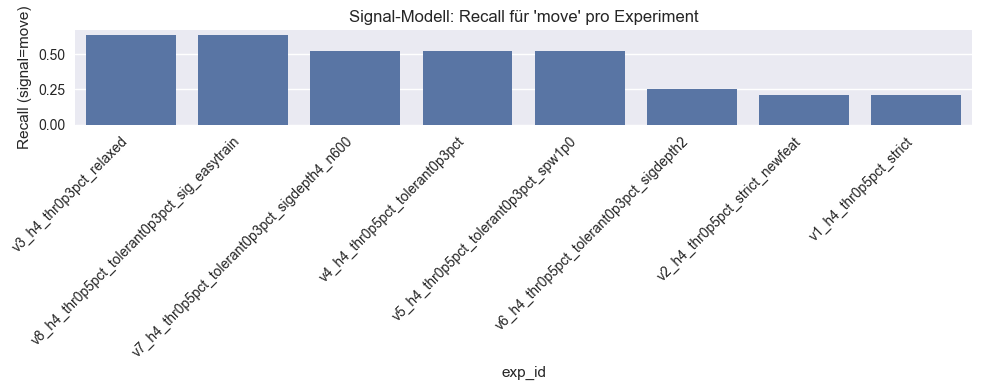

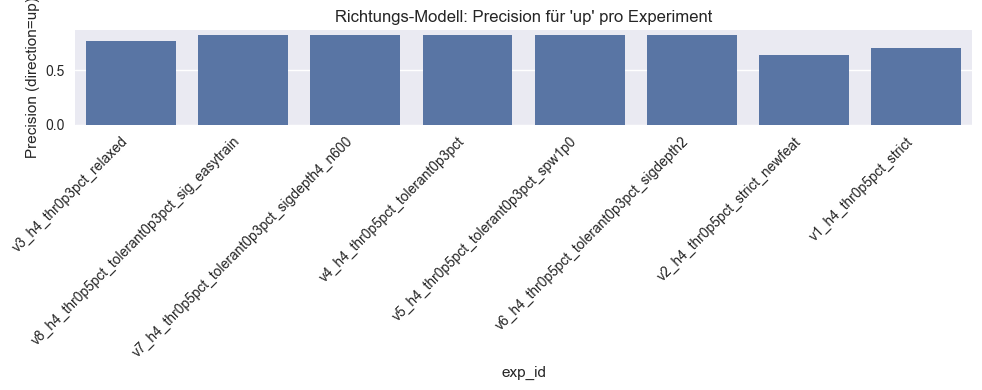

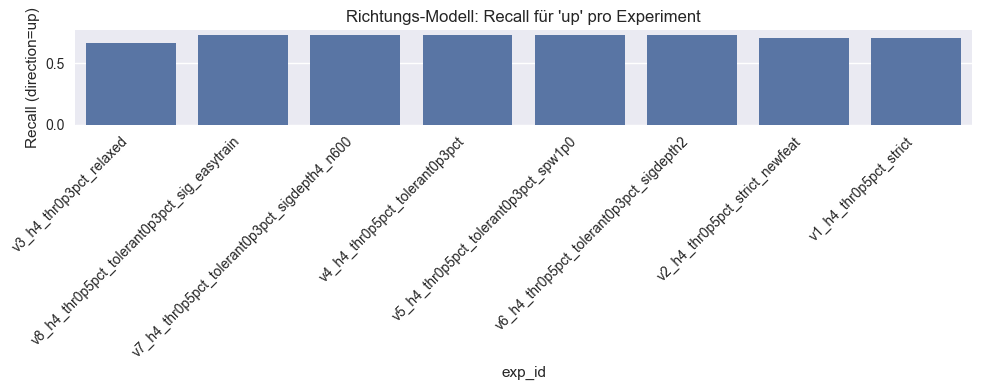

In [12]:
if not summary_df.empty:
    # Sortierung z.B. nach Precision der 'move'-Klasse
    summary_df_sorted = summary_df.sort_values("signal_precision_move", ascending=False)

    plt.figure(figsize=(10, 4))
    sns.barplot(data=summary_df_sorted, x="exp_id", y="signal_precision_move")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Precision (signal=move)")
    plt.title("Signal-Modell: Precision für 'move' pro Experiment")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.barplot(data=summary_df_sorted, x="exp_id", y="signal_recall_move")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Recall (signal=move)")
    plt.title("Signal-Modell: Recall für 'move' pro Experiment")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.barplot(data=summary_df_sorted, x="exp_id", y="direction_precision_up")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Precision (direction=up)")
    plt.title("Richtungs-Modell: Precision für 'up' pro Experiment")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.barplot(data=summary_df_sorted, x="exp_id", y="direction_recall_up")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Recall (direction=up)")
    plt.title("Richtungs-Modell: Recall für 'up' pro Experiment")
    plt.tight_layout()
    plt.show()
else:
    print("Keine Ergebnis-Dateien gefunden. Bitte zuerst Experimente ausführen und JSONs speichern.")
